<h1><b>SCRAPING-CITRA-SATELIT</b></h1>

---

📝 **Notebook: scraping_citra_satelit.ipynb**

Notebook ini digunakan untuk melakukan **scraping citra satelit bangunan sekolah** dari **14.927 sekolah SMA di Indonesia**.  

---

📂 **Sumber Data**

Data input yang digunakan dalam proses scraping ini berupa:  
- **Nama sekolah**  
- **Kabupaten/Kota**  
- **Provinsi**  

Data tersebut diperoleh dari tahap sebelumnya (scraping data sekolah Kemendikbud) dan tersedia dalam [**Google Spreadsheet**](https://docs.google.com/spreadsheets/d/1eJ-uylcTjo_OGhcih7pgacc28KCz9Y8bx6tNw1157GM/).

---

⚙️ **Tahapan Scraping Citra Satelit**

Beberapa langkah yang dilakukan di notebook ini:  

1. **LIBRARY**  
- Import library yang dibutuhkan untuk scraping dan manipulasi data.

2. **CONFIGURATION**
- Menyiapkan Google Spreadsheet API untuk sinkronasi data input dan output (hasil scraping profil)

3. **SCRAPING**  
   1. **Pencarian Koordinat Geografi**  
      Mencari titik koordinat berdasarkan Nama Sekolah, Kabupaten/Kota, dan Provinsi.  

   2. **Pengambilan Citra Satelit**  
      Mengambil citra satelit berdasarkan koordinat geografi (longitude, latitude) yang telah diperoleh sebelumnya.  

   3. **Penambahan Anotasi**  
      Menambahkan informasi pada citra satelit, seperti titik dan bounding box, untuk mempermudah analisis.  

   4. **Integrasi Proses**  
      Menggabungkan proses 1, 2, dan 3 menjadi satu fungsi yang utuh agar efisien dan mudah digunakan.

---

📊 **Hasil yang Diperoleh**

Proses scraping ini akan menghasilkan:  

- **Citra satelit bangunan sekolah** dalam tiga format:  

<div style="display: flex; justify-content: space-around;">
  <div align="center">
    <p><b>Original (ori)</b></p>
    <img src="gambar/sampel-ori.jpg" alt="Contoh citra original" width="250"/>
  </div>
  <div align="center">
    <p><b>YOLO (bounding box)</b></p>
    <img src="gambar/sampel-yolo.jpg" alt="Contoh citra YOLO" width="250"/>
  </div>
  <div align="center">
    <p><b>Titik (lokasi sekolah)</b></p>
    <img src="gambar/sampel-titik.jpg" alt="Contoh citra titik lokasi" width="250"/>
  </div>
</div>

- **Koordinat geografis**: longitude dan latitude setiap sekolah  

**Data Gambar**  
`../hasil/gambar_ori`  
`../hasil/gambar_titik`  
`../hasil/gambar_kotak_dan_yolo`  

**Data Tabel**  
🗂️ **[Data Semua SMA – Worksheet: scraping-maps](https://docs.google.com/spreadsheets/d/1eJ-uylcTjo_OGhcih7pgacc28KCz9Y8bx6tNw1157GM)**

---

📌 **Tujuan Penggunaan Data**  

Data hasil scraping citra satelit ini akan digunakan untuk tahap-tahap analisis lanjutan, antara lain:  
- Visualisasi peta sebaran 14.927 sekolah SMA di Indonesia.  
- Analisis *clustering* sekolah berbasis citra satelit.  
- Klasifikasi sekolah menggunakan model *machine learning*.  
- Deployment model dan aplikasi.

---


---
# **LIBRARY**
---

In [1]:
# ============================
# Standard Library
# ============================
import os                      # Operasi sistem (folder, path, dsb)
import math                    # Fungsi matematika (ceil, floor, dsb)
import re                      # Ekspresi reguler (parsing teks)
import time                    # Delay / sleep
import urllib                  # Operasi URL

from rapidfuzz import fuzz     # String matching / fuzzy matching

# ============================
# Image Processing
# ============================
from PIL import Image, ImageDraw    # Membuka, memproses, dan anotasi gambar
import IPython.display as ipd       # Display gambar di notebook

# ============================
# Web Automation / Scraping
# ============================
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

# ============================
# Google Sheets API
# ============================
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# ============================
# Concurrency / Parallel Processing
# ============================
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm                # Progress bar untuk multi-worker


---
# **GOOGLE SPREADSHEETS**
---

Pada proses ini **file akan disimpan dan disinkronkan menggunakan Google Sheets**, sehingga progres scraping dapat dipantau secara **real-time**.  

Sebelum menjalankan notebook ini, ada beberapa hal yang perlu disiapkan:

1. **File Google Spreadsheet** yang dapat diakses di [data_semua_sma](https://docs.google.com/spreadsheets/d/1eJ-uylcTjo_OGhcih7pgacc28KCz9Y8bx6tNw1157GM).  
2. **Service Account** dengan akses API Google Spreadsheet, diperoleh melalui **Google Cloud Console**.  
   > ⚠️ Untuk keamanan, credentials service account **tidak dicantumkan** di notebook.

Bagian ini berisi fungsi-fungsi untuk:  
1. `auth(data)` → Mengautentikasi dan mengembalikan client gspread.  
2. `start(data, id_sheet)` → Membuka worksheet 'scraping-maps' dari spreadsheet.  
3. `ambil_baris(sheet, i)` → Mengambil nilai dari baris ke-i pada worksheet.  
4. `simpan(sheet, data, i)` → Menyimpan/update data ke baris ke-i pada worksheet. 
> ⚠️ Kolom yang digunakan dalam spreadsheet harus sesuai format yang ditentukan.

In [2]:
# ============================
# Fungsi autentikasi
# ============================
def auth(data):
    scope = [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive"
    ]
    creds = ServiceAccountCredentials.from_json_keyfile_dict(data, scope)
    client = gspread.authorize(creds)
    return client

# ============================
# Fungsi mulai akses spreadsheet
# ============================
def start(data, id_sheet):
    client = auth(data)
    sheet = client.open_by_key(id_sheet).worksheet('scraping-maps') # Nama Worksheet
    return client, sheet

# ============================
# Fungsi mengambil data baris
# ============================
def ambil_baris(sheet, i):
    try:
        return sheet.row_values(i+1) # +1 karena data dimulai pada baris ke-2 (baris pertama merupakan header)
    except Exception as e:
        print(f"Error ketika mengambil data baris ke-{i}: {e}")
        return 0

# ============================
# Fungsi menyimpan data
# ============================
def simpan(sheet, data, i):
    if len(data) != 6:
      raise ValueError("data harus berisi tepat 6 elemen (J-O)") 
    
    time.sleep(1)
    
    cell_range = f"J{i+1}:O{i+1}"

    try:
      sheet.update(range_name=cell_range, values=[data])
    except Exception as e:
      print(f"Error ketika mengupdate data baris ke-{i}: {e}")

In [3]:
# ID dari Google spreadsheets yang digunakan
id_sma = '1eJ-uylcTjo_OGhcih7pgacc28KCz9Y8bx6tNw1157GM' # Berisi file SMA

# Berikut ini adalah data Service Account 
laptop_aziz = {
    # Rahasia, ganti dengan service account saudara sendiri.
}
# Mengoneksikan dengan Google Spreadsheets
client, sheet = start(data=laptop_aziz, id_sheet=id_sma)

---
# **SCRAPING**
---

⚙️ **Alur Proses Scraping Citra Satelit**  

Proses scraping citra satelit dalam proyek ini dibagi menjadi **empat tahap utama**:  

1. **Pencarian Koordinat Geografi**  
   - Berdasarkan data `nama sekolah`, `kabupaten/kota`, dan `provinsi` dari hasil scraping sebelumnya.  
   - Fungsi akan mencari **koordinat geografis (latitude & longitude)** dari masing-masing sekolah menggunakan Google Maps.  

2. **Pengambilan Citra Satelit**  
   - Setelah koordinat diperoleh, sistem melakukan **request citra satelit** berdasarkan titik lokasi.  
   - Citra disimpan dalam folder:  
     `"../hasil/gambar_ori/PROVINSI/KOTA/nama_sekolah.jpg"`  

3. **Penambahan Anotasi (Bounding Box & Titik Lokasi)**  
   - **Titik lokasi (point marker)** ditambahkan pada pusat sekolah.  
     - Disimpan di: `"../hasil/gambar_titik/PROVINSI/KOTA/nama_sekolah.jpg"`  
   - **Bounding box (YOLO format)** ditambahkan untuk menandai area bangunan sekolah.  
     - Disimpan di:  
       - Gambar: `"../hasil/gambar_kotak_dan_yolo/PROVINSI/KOTA/img/nama_sekolah.jpg"`  
       - Label YOLO: `"../hasil/gambar_kotak_dan_yolo/PROVINSI/KOTA/yolo/nama_sekolah.txt"`  
   - Format ini membuat citra siap digunakan untuk **training model computer vision** (misalnya YOLO) maupun **analisis visualisasi sebaran**.  

4. **Integrasi Proses**  
   - Semua langkah digabung menjadi **satu workflow otomatis**.  
   - Fungsi `scraping_citra_satelit()` menjalankan:  
     1. Mengambil data `nama sekolah`, `kabupaten/kota`, dan `provinsi` dari [Google Sheet (worksheet `scraping-profil`)](https://docs.google.com/spreadsheets/d/1eJ-uylcTjo_OGhcih7pgacc28KCz9Y8bx6tNw1157GM/).  
     2. Melakukan seluruh proses scraping citra satelit:  
        - Pencarian koordinat geografis.  
        - Pengambilan citra satelit (tile download & stitch).  
        - Penambahan anotasi (titik lokasi & bounding box).  
     3. Menyimpan hasil dan dokumentasi ke [Google Sheet (worksheet `scraping-maps`)](https://docs.google.com/spreadsheets/d/1eJ-uylcTjo_OGhcih7pgacc28KCz9Y8bx6tNw1157GM/).  

- **Hasil akhir:** citra siap pakai untuk analisis visual dan training model, dengan **struktur folder yang terorganisir**.


---
## 1. Pencarian Koordinat Geografi
---

Fungsi `get_latlon_from_gmaps`

Fungsi ini digunakan untuk mendapatkan:  
- **Nama resmi lokasi** dari Google Maps  
- **Koordinat geografi** berupa *latitude* dan *longitude*  

Proses Kerja
1. Membuka halaman pencarian Google Maps dengan query `nama sekolah + kota + provinsi`.  
2. Mengambil teks nama lokasi resmi dari elemen dengan class `DUwDvf`.  
3. Jika Google Maps tidak yakin dengan nama, fungsi akan memilih kandidat nama dari daftar lokasi (`NrDZNb`).  
4. Mengekstrak koordinat `(lat, lon)` dari URL hasil pencarian.  
5. Mengembalikan data berupa tuple: `(nama_resmi, lat, lon)`.

⚠️ Catatan:  
- Fungsi ini menggunakan **Selenium WebDriver (Chrome)** dalam mode headless.  
- Tambahkan `waktu_tunggu` yang cukup agar halaman termuat sempurna.  
- Jika pemilihan nama kandidat dilakukan dan akurasi < 0.99, hasil akan diberi tag `CEK KEMBALI`.
- Jika gagal menemukan lokasi, fungsi mengembalikan nama `"tidak_ditemukan"` dan koordinat `(0.0, 0.0)`.


In [4]:
# ============================
# Fungsi bantu ekstraksi nama
# ============================
def extract_NrDZnb(list_lokasi):
    """Mengambil teks dari list elemen lokasi (saat scraping Google Maps)."""
    return [lokasi.text for lokasi in list_lokasi]

# ============================
# Fungsi cek kemiripan nama
# ============================
def cek_kemiripan(nama1, nama2):
    """
    Menghitung skor kemiripan antara dua nama sekolah.
    Penalti diberikan jika jenjang berbeda (misal SMP/SD).
    """
    # Mapping singkatan ke bentuk lengkap
    mapping = {
        "SMAN": "SMA Negeri",
        "SMA N ": "SMA Negeri",
        "SMAS": "SMA Swasta",
        "SMA S ": "SMA Swasta",
    }
    for singkat, lengkap in mapping.items():
        nama1 = nama1.replace(singkat, lengkap)
        nama2 = nama2.replace(singkat, lengkap)

    # Normalisasi: hapus karakter non-alfanumerik, ubah ke lowercase
    nama1_norm = re.sub(r"[^\w\s]", "", nama1.lower())
    nama2_norm = re.sub(r"[^\w\s]", "", nama2.lower())

    # Penalti untuk jenjang berbeda
    penalti = 0.5 if "smp " in nama2_norm or "sd " in nama2_norm or "smk " in nama2_norm else 0.0

    # Hitung skor berbasis kata (token set)
    score = fuzz.token_set_ratio(nama1_norm, nama2_norm) / 100.0
    score = max(score - penalti, 0.0)  # jangan sampai negatif

    return score

# ============================
# Fungsi pilih nama terbaik
# ============================
def pilih_nama(list_lokasi, nama_asli):
    """
    Memilih nama terbaik dari kandidat list_lokasi berdasarkan kemiripan dengan nama_asli.
    """
    list_nama = extract_NrDZnb(list_lokasi)
    if not list_nama:
        return "tidak_ditemukan (0.0)"

    best_name = None
    best_score = -1.0
    kandidat_log = []

    for kandidat in list_nama:
        score = cek_kemiripan(nama_asli, kandidat)
        kandidat_log.append(f"{kandidat} ({score:.2f})")
        if score > best_score:
            best_name = kandidat
            best_score = score

    # Bisa diaktifkan untuk debugging:
    # print(f"\t[{nama_asli}] Checking... :", " | ".join(kandidat_log))

    return best_name, f"{best_score:.2f}"

# ============================
# Fungsi ambil koordinat dari Google Maps
# ============================
def get_latlon_from_gmaps(name, city="", prov="", waktu_tunggu=4):
    """
    Mengambil nama resmi, latitude, dan longitude dari Google Maps.
    Melakukan retry jika nama resmi diambil dari daftar kandidat.
    """
    def _fetch(query_name, akurasi=0):
        query = f"{query_name}, {city}".replace(" ", "+")
        url = f"https://www.google.com/maps/search/{query}"

        options = Options()
        options.add_argument("--headless=new")
        options.add_argument("--disable-gpu")
        options.add_argument("--no-sandbox")

        driver = webdriver.Chrome(options=options)
        driver.set_page_load_timeout(20)

        ulang = False
        try:
            driver.get(url)
            time.sleep(waktu_tunggu)

            try:
                # Jika Maps yakin → ambil nama resmi
                nama_resmi = driver.find_element(By.CLASS_NAME, "DUwDvf").text
            except:
                # Jika Maps bingung → ambil dari list kandidat
                list_lokasi = driver.find_elements(By.CLASS_NAME, "NrDZNb")
                ulang = True
                if list_lokasi:
                    nama_resmi, akurasi = pilih_nama(list_lokasi, query_name)
                else:
                    nama_resmi = "Tidak Ditemukan"

            current_url = driver.current_url

            # Regex ambil koordinat
            match = re.search(r'/@(-?\d+\.\d+),(-?\d+\.\d+)', current_url)
            if match:
                lat, lon = float(match.group(1)), float(match.group(2))
            else:
                lat, lon = 0.0, 0.0

            return nama_resmi, lat, lon, ulang, akurasi

        except TimeoutException:
            print(f"⚠️ Timeout 20 detik untuk {query_name}. Lanjutkan...")
            return "tidak_ditemukan", 0.0, 0.0, ulang, 0

        finally:
            driver.quit()

    # --- eksekusi utama ---
    nama_resmi, lat, lon, ulang, akurasi = _fetch(name)

    # Retry jika perlu pemilihan nama
    if ulang:
        # print(f"🔄 Retry dengan nama_resmi: {nama_resmi}")
        nama_resmi2, lat, lon, _, akurasi = _fetch(nama_resmi, akurasi)
        if float(akurasi) < 0.99:
            return f"{nama_resmi2} ({akurasi}) CEK KEMBALI", lat, lon
        return nama_resmi2, lat, lon

    return nama_resmi, lat, lon

In [5]:
# Test Fungsi
dummy = get_latlon_from_gmaps("SMA Negeri 1 Semarang", "Semarang", "Jawa Tengah")
print(f"nama: {dummy[0]} \nlatitude: {dummy[1]} \nlongitude: {dummy[2]}")

nama: SMA Negeri 1 Semarang 
latitude: -6.9919341 
longitude: 110.4188328


---
## 2. Pengambilan Citra Satelit
---

📌 Konsep Baris dan Kolom pada Tile Peta

Sebelum melakukan pengambilan citra satelit, penting untuk memahami konsep **baris dan kolom** pada tile peta.

Pada peta berbasis **Web Mercator Projection** (misalnya Google Maps, OpenStreetMap, Leaflet), dunia dibagi menjadi **kotak-kotak kecil (tiles)**.  
Setiap tile memiliki **koordinat baris (`y_tile`)** dan **kolom (`x_tile`)**.


🔹 Kolom (`x_tile`)
- Menunjukkan posisi **horizontal** tile.  
- Dihitung dari **barat (longitude = -180°)** ke **timur (longitude = +180°)**.  
- `x_tile = 0` → tile paling kiri.  
- Nilai `x_tile` meningkat ke kanan seiring pergerakan ke timur.

🔹 Baris (`y_tile`)
- Menunjukkan posisi **vertikal** tile.  
- Dihitung dari **utara (latitude ≈ +85°)** ke **selatan (latitude ≈ -85°)**.  
- `y_tile = 0` → tile paling atas.  
- Nilai `y_tile` meningkat ke bawah seiring pergerakan ke selatan.


📊 Grid Tile dengan Visualisasi Gambar

<!-- Zoom 0 -->
<div style="display: flex; align-items: flex-start; gap: 20px; margin-bottom: 30px;">
  <!-- Tabel di kiri -->
  <div>
    <strong>🔹 Zoom 0</strong><br>
    Jumlah tile: <code>2^0 = 1</code> <br>
    Tile ini mewakili seluruh dunia pada zoom 0. <br><br>
    <table border="1" cellpadding="4" cellspacing="0">
      <tr><th>y \ x</th><th>x=0</th></tr>
      <tr><td>y=0</td><td>(0,0)</td></tr>
    </table>
  </div>
  <!-- Gambar di kanan -->
  <div>
    <br><br><br>
    <img src="gambar/zoom-0.png" width="300"/>
  </div>
</div>

<!-- Zoom 1 -->
<div style="display: flex; align-items: flex-start; gap: 20px; margin-bottom: 30px;">
  <div>
    <strong>🔹 Zoom 1</strong><br>
    Jumlah tile: <code>2^1 = 2</code> <br>
    Tile Zoom 2 membagi dunia menjadi 2x2 kotak.<br><br>
    <table border="1" cellpadding="4" cellspacing="0">
      <tr><th>y \ x</th><th>x=0</th><th>x=1</th></tr>
      <tr><td>y=0</td><td>(0,0)</td><td>(1,0)</td></tr>
      <tr><td>y=1</td><td>(0,1)</td><td>(1,1)</td></tr>
    </table>
  </div>
  <div>
    <br><br><br>
    <img src="gambar/zoom-1.png" width="300"/>
  </div>
</div>

<!-- Zoom 2 -->
<div style="display: flex; align-items: flex-start; gap: 20px; margin-bottom: 30px;">
  <div>
    <strong>🔹 Zoom 2</strong><br>
    Jumlah tile: <code>2^2 = 4</code> <br>
    Tile Zoom 2 membagi dunia menjadi 4x4 kotak.<br><br>
    <table border="1" cellpadding="4" cellspacing="0">
      <tr><th>y \ x</th><th>x=0</th><th>x=1</th><th>x=2</th><th>x=3</th></tr>
      <tr><td>y=0</td><td>(0,0)</td><td>(1,0)</td><td>(2,0)</td><td>(3,0)</td></tr>
      <tr><td>y=1</td><td>(0,1)</td><td>(1,1)</td><td>(2,1)</td><td>(3,1)</td></tr>
      <tr><td>y=2</td><td>(0,2)</td><td>(1,2)</td><td>(2,2)</td><td>(3,2)</td></tr>
      <tr><td>y=3</td><td>(0,3)</td><td>(1,3)</td><td>(2,3)</td><td>(3,3)</td></tr>
    </table>
  </div>
  <div>
    <br><br><br>
    <img src="gambar/zoom-2.png" width="300"/>
  </div>
</div>

📌 Zoom 18 dan Tile Peta

Dalam kasus ini, **zoom yang digunakan adalah 18**.  
Jumlah tile per baris/kolom = `2^18 = 262,144` → total tile = 262,144 × 262,144.  

**Alasan:**  
Zoom 18 sangat detail → setiap tile mewakili area kecil di bumi (±1–2 meter per pixel), sehingga bangunan sekolah dapat dianalisis dengan presisi tinggi.

**Manfaat resolusi ini:**
- Citra satelit menangkap detail bangunan, jalan, dan lahan sekolah secara akurat.  
- Memungkinkan analisis berbasis tile, misalnya klasifikasi atau deteksi objek, dengan presisi tinggi.  
- Perlu diperhatikan, jumlah tile sangat besar → biasanya hanya area relevan yang diunduh.

**Contoh tile untuk SMA Negeri 1 Semarang:**
- Latitude: `-6.9919341`  
- Longitude: `110.4188328`  
- Zoom: `18`  

Hasil koordinat tile:  
- `Tile X = 142279` → posisi horizontal tile  
- `Tile Y = 86697` → posisi vertikal tile  

Fungsi `latlon_to_tile(lat, lon, zoom)`

**Tujuan:**  
Mengubah koordinat geografis `(latitude, longitude)` menjadi **koordinat tile X/Y** pada zoom tertentu.

**Parameter:**
- `lat` → latitude (derajat)
- `lon` → longitude (derajat)
- `zoom` → level zoom (0 = seluruh dunia 1 tile, semakin besar zoom → semakin detail)

In [6]:
def latlon_to_tile(lat, lon, zoom):
    x_tile = int((lon + 180) / 360 * (2 ** zoom))  # hitung kolom tile (x)
    y_tile = int((1 - math.log(math.tan(math.radians(lat)) + 1 / math.cos(math.radians(lat))) / math.pi) / 2 * (2 ** zoom))  # hitung baris tile (y)
    return x_tile, y_tile

In [7]:
# Contoh untuk SMA Negeri 1 Semarang
dummy_lat = -6.9919341
dummy_long = 110.4188328
dummy_zoom = 18

dummy_x, dummy_y = latlon_to_tile(dummy_lat, dummy_long, dummy_zoom)
print(f"Tile X: {dummy_x} \nTile Y: {dummy_y}")

Tile X: 211476 
Tile Y: 136176


Fungsi `download_tile(x, y, z, folder)`

Fungsi ini digunakan untuk **mengunduh tile peta satelit** dari Google Maps dan menyimpannya ke folder lokal.

**Parameter**
- `x` → indeks kolom tile (`x_tile`)  
- `y` → indeks baris tile (`y_tile`)  
- `z` → zoom level  
- File tile akan disimpan di folder `../hasil/tile/`. 


In [8]:
def download_tile(x, y, z):    
    folder = "../hasil/tile"
    os.makedirs(folder, exist_ok=True)
    
    # Menyusun URL tile Google Maps (layer satelit)
    url = f"https://mts0.google.com/vt/lyrs=s&x={x}&y={y}&z={z}"
    
    # Nama file untuk tile
    filename = f"{folder}/tile_{x}_{y}_{z}.jpg"
    
    # Unduh tile jika belum ada
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url, filename)
        except Exception as e:
            print(f"❌ Gagal download tile ({x}, {y}, {z}): {e}")
            return None  # atau bisa raise e jika ingin menghentikan proses
    
    # Kembalikan path file
    return filename

SMA Negeri 1 Semarang
Koordinat = (-6.9919341, 110.4188328)
Zoom: 18
Tile = (211476, 136176)


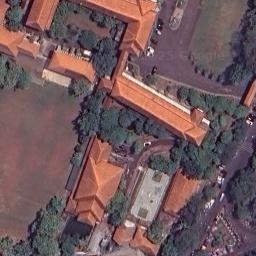

In [9]:
# Contoh untuk SMA Negeri 1 Semarang
dummy_path = download_tile(dummy_x, dummy_y, dummy_zoom)

print("SMA Negeri 1 Semarang")
print(f"Koordinat = ({dummy_lat}, {dummy_long})")
print(f"Zoom: 18")
print(f"Tile = ({dummy_x}, {dummy_y})")
ipd.display(ipd.Image(filename=dummy_path))

**Tanpa Penggabungan Tile**
- Jika kita hanya mengambil **satu tile** berdasarkan koordinat pusat sekolah, hasilnya **tidak mencakup seluruh bangunan**.  
- Hal ini karena **satu tile pada zoom 18 hanya mencakup area kecil** (±1–2 meter per pixel).  
- Contoh: SMA Negeri 1 Semarang → sebagian bangunan terpotong jika hanya mengambil 1 tile.

**Perlu Penggabungan Tile**
- Solusinya: **mengambil tile di sekitar titik pusat** dan menggabungkannya menjadi satu citra besar.  
- Konsepnya:
  - Titik pusat → koordinat tile `(x_center_tile, y_center_tile)`  
  - Ambil tile di sekitarnya (misal 3x3 tile)  
  - Gabungkan tile menjadi satu gambar (stitched image)  
- Hasil: seluruh area sekolah terlihat utuh, siap untuk analisis.


In [10]:
def download_and_stitch(lat, lon, nama_file, ZOOM_LEVEL, ORI_DIR):
    os.makedirs(ORI_DIR, exist_ok=True)
    
    x_center_tile, y_center_tile = latlon_to_tile(lat, lon, ZOOM_LEVEL)
    stitched = Image.new('RGB', (256 * 3, 256 * 3))

    for dx in range(-1, 2):
        for dy in range(-1, 2):
            x = x_center_tile + dx
            y = y_center_tile + dy
            tile_path = download_tile(x, y, ZOOM_LEVEL)
            tile_img = Image.open(tile_path)
            stitched.paste(tile_img, ((dx + 1) * 256, (dy + 1) * 256))

    # === Simpan gambar original ===
    ori_path = os.path.join(ORI_DIR, f"{nama_file}.jpg")
    stitched.save(ori_path)
    return stitched, ori_path

SMA Negeri 1 Semarang (3x3 tile)


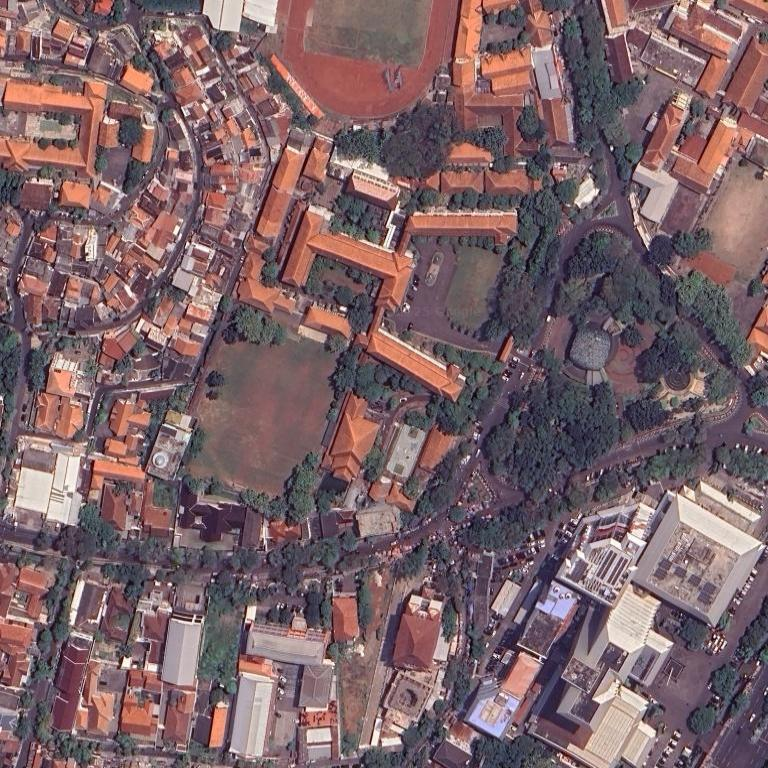

In [11]:
dummy_ori_dir = "../hasil/gambar_ori/JAWA TENGAH/KOTA SEMARANG"
dummy_nama_file = "sma_negeri_1_semarang"


dummy_stitched, dummy_ori_path = download_and_stitch(dummy_lat, dummy_long, dummy_nama_file, dummy_zoom, dummy_ori_dir)

print("SMA Negeri 1 Semarang (3x3 tile)")
ipd.display(ipd.Image(filename="../hasil/gambar_ori/JAWA TENGAH/KOTA SEMARANG/sma_negeri_1_semarang.jpg"))

---
## 3. Penambahan Anotasi (Bounding Box dan Titik Lokasi)
---

1️⃣ Menambahkan Anotasi Titik Lokasi

Titik lokasi akan ditambahkan pada **citra satelit** sesuai dengan koordinat lokasi (latitude, longitude).  
Proses ini berguna untuk **menandai posisi bangunan sekolah atau objek tertentu**.

**Langkah-langkah**
1. **Konversi koordinat geografis ke pixel**  
   - Gunakan fungsi `latlon_to_pixel(lat, lon, zoom)` untuk mendapatkan **koordinat pixel** dari latitude dan longitude pada zoom tertentu.  
   - Koordinat pixel ini akan digunakan sebagai posisi titik pada gambar gabungan (stitched image).

2. **Menambahkan titik lokasi pada citra**  
   - Fungsi `add_titik_lokasi()` menerima citra gabungan dan koordinat pixel.  
   - Titik lokasi digambar **di atas citra** sehingga mudah dikenali, berbentuk lingkaran berwarna biru.

**Manfaat**
- Memberikan **referensi visual** pada citra satelit.  
- Memudahkan **analisis spasial**, seperti deteksi bangunan atau penandaan area sekolah.  
- Bisa dikombinasikan dengan **anotasi tambahan** (bounding box, label) untuk analisis berbasis tile.

2️⃣ Menambahkan Anotasi Bounding Box

Fungsi `add_bounding_box()` digunakan untuk **menambahkan kotak pembatas (bounding box)** pada citra satelit gabungan (stitched image) sesuai dengan koordinat lokasi sekolah atau objek lain.  
Selain itu, fungsi ini juga membuat **label YOLO** untuk keperluan deteksi objek berbasis deep learning.


**Langkah-langkah**
1. **Hitung tile pusat dan koordinat pixel lokal**  
   - Gunakan `latlon_to_tile()` untuk menentukan tile pusat dari koordinat lokasi.  
   - Gunakan `latlon_to_pixel()` untuk menghitung koordinat pixel global.  
   - Hitung koordinat **lokal relatif di stitched image**:
     ```python
     local_px = global_px - tile_origin_x
     local_py = global_py - tile_origin_y
     ```

2. **Hitung ukuran bounding box**  
   - Gunakan `meter_per_pixels()` untuk menghitung **berapa banyak meter yang direpresentasikan oleh satu pixel** pada level zoom tertentu.  
   - Berdasarkan **meters per pixel (mpp)** dan ukuran objek yang ingin dianotasi, misalnya 250×250 meter.  
   - Bounding box digambar **di atas citra**, berbentuk kotak biru dengan ketebalan tertentu.

3. **Simpan citra dengan bounding box**  
   - File disimpan di folder `BOX_DIR` sesuai nama file.

4. **Simpan label YOLO**  
   - Koordinat bounding box dinormalisasi terhadap ukuran citra (`x_center_rel`, `y_center_rel`, `width_rel`, `height_rel`).  
   - Label disimpan dalam folder `YOLO_DIR` dengan format:
     ```
     class x_center y_center width height
     ```

**Manfaat**
- Memberikan **referensi visual ukuran dan lokasi objek** pada citra satelit.  
- Mempermudah **analisis spasial** dan **persiapan dataset deteksi objek**.  
- Label YOLO memudahkan integrasi dengan model **object detection** berbasis deep learning.

In [12]:
def latlon_to_pixel(lat, lon, zoom):
    lat_rad = math.radians(lat)
    n = 2 ** zoom
    x_pixel = ((lon + 180) / 360) * n * 256
    y_pixel = (1 - math.log(math.tan(lat_rad) + 1 / math.cos(lat_rad)) / math.pi) / 2 * n * 256
    return x_pixel, y_pixel

def meters_per_pixel(lat, zoom):
    return 156543.03392 * math.cos(math.radians(lat)) / (2 ** zoom)

In [13]:
def add_titik_lokasi(stitched_ori, lat, lon, nama_file, ZOOM_LEVEL, TITIK_DIR):
    os.makedirs(TITIK_DIR, exist_ok=True)
    x_center_tile, y_center_tile = latlon_to_tile(lat, lon, ZOOM_LEVEL)
    
    # === Hitung koordinat piksel lokal ===
    global_px, global_py = latlon_to_pixel(lat, lon, ZOOM_LEVEL)
    tile_origin_x = (x_center_tile - 1) * 256
    tile_origin_y = (y_center_tile - 1) * 256
    local_px = global_px - tile_origin_x
    local_py = global_py - tile_origin_y

    # === Simpan gambar dengan titik lokasi ===
    titik_image = stitched_ori.copy()
    titik_draw = ImageDraw.Draw(titik_image)
    titik_draw.ellipse([
        (local_px - 10, local_py - 10),
        (local_px + 10, local_py + 10)
    ], fill='blue')
    titik_path = os.path.join(TITIK_DIR, f"{nama_file}.jpg")
    titik_image.save(titik_path)
    return titik_path

In [14]:
def add_bounding_box(stitched_ori, lat, lon, nama_file, ZOOM_LEVEL, BOX_DIR, YOLO_DIR):
    os.makedirs(BOX_DIR, exist_ok=True)
    os.makedirs(YOLO_DIR, exist_ok=True)
    x_center_tile, y_center_tile = latlon_to_tile(lat, lon, ZOOM_LEVEL)
    
    # === Hitung koordinat piksel lokal ===
    global_px, global_py = latlon_to_pixel(lat, lon, ZOOM_LEVEL)
    tile_origin_x = (x_center_tile - 1) * 256
    tile_origin_y = (y_center_tile - 1) * 256
    local_px = global_px - tile_origin_x
    local_py = global_py - tile_origin_y
    
    # === Hitung ukuran bounding box dan gambar kotak biru ===
    mpp = meters_per_pixel(lat, ZOOM_LEVEL)
    bbox_w = int(250 / mpp)
    bbox_h = int(250 / mpp)

    kotak_image = stitched_ori.copy()
    kotak_draw = ImageDraw.Draw(kotak_image)
    kotak_draw.rectangle([
        (local_px - bbox_w // 2, local_py - bbox_h // 2),
        (local_px + bbox_w // 2, local_py + bbox_h // 2)
    ], outline='blue', width=5)
    box_path = os.path.join(BOX_DIR, f"{nama_file}.jpg")
    kotak_image.save(box_path)

    # === Simpan label YOLO ===
    img_width, img_height = stitched_ori.size
    x_center_rel = local_px / img_width
    y_center_rel = local_py / img_height
    width_rel = bbox_w / img_width
    height_rel = bbox_h / img_height

    yolo_path = os.path.join(YOLO_DIR, f"{nama_file}.txt")
    with open(yolo_path, "w") as f:
        f.write(f"0 {x_center_rel:.6f} {y_center_rel:.6f} {width_rel:.6f} {height_rel:.6f}\n")
        
    return box_path, yolo_path

In [15]:
dummy_tiitk_dir = "../hasil/gambar_titik/JAWA TENGAH/KOTA SEMARANG"
dummy_box_dir = "../hasil/gambar_kotak_dan_yolo/JAWA TENGAH/KOTA SEMARANG/img"
dummy_yolo_dir = "../hasil/gambar_kotak_dan_yolo/JAWA TENGAH/KOTA SEMARANG/yolo"

dummy_titik_path = add_titik_lokasi(dummy_stitched, dummy_lat, dummy_long, dummy_nama_file, dummy_zoom, dummy_tiitk_dir)
dummy_box_path, dummy_yolo_path = add_bounding_box(dummy_stitched, dummy_lat, dummy_long, dummy_nama_file, dummy_zoom, dummy_box_dir, dummy_yolo_dir)

3️⃣ Menggabungkan Seluruh Proses Scraping Citra Satelit

Fungsi `download_citra_satelit()` menggabungkan **seluruh proses pengolahan citra satelit** menjadi satu langkah otomatis:  
1. **Download dan gabung tile (stitched image)**  
2. **Menambahkan anotasi titik lokasi**  
3. **Menambahkan anotasi bounding box + label YOLO**

**Parameter**
- `lat`, `lon` → koordinat lokasi titik pusat objek  
- `nama_file` → nama file hasil simpan  
- `ZOOM_LEVEL` → level zoom citra  
- `ORI_DIR` → folder penyimpanan citra stitched asli  
- `TITIK_DIR` → folder penyimpanan citra dengan titik lokasi  
- `BOX_DIR` → folder penyimpanan citra dengan bounding box  
- `YOLO_DIR` → folder penyimpanan label YOLO

 **Alur Kerja Fungsi**

1. **Download dan stitch tile**  
   - Memanggil `download_and_stitch()` untuk mengunduh beberapa tile di sekitar koordinat lokasi dan digabung menjadi **stitched image**.  
   - Hasilnya disimpan di folder `ORI_DIR`.

2. **Tambahkan anotasi titik lokasi**  
   - Memanggil `add_titik_lokasi()` untuk menambahkan **titik biru** pada lokasi objek di stitched image.  
   - Hasil disimpan di folder `TITIK_DIR`.

3. **Tambahkan bounding box dan label YOLO**  
   - Memanggil `add_bounding_box()` untuk menggambar kotak biru di sekitar objek dan menyimpan **label YOLO**.  
   - Hasil citra disimpan di `BOX_DIR` dan label YOLO di `YOLO_DIR`.

**Manfaat**
- Menyederhanakan proses pengambilan citra satelit, anotasi titik, dan bounding box menjadi **satu fungsi terpadu**.  
- Cocok untuk **batch processing** banyak lokasi sekolah atau objek lain.  
- Memastikan semua hasil citra dan label tersimpan dengan konsisten di folder masing-masing.


In [16]:
def download_citra_satelit(lat, lon, nama_file, ZOOM_LEVEL, ORI_DIR, TITIK_DIR, BOX_DIR, YOLO_DIR):
    stitched, ori_path = download_and_stitch(lat, lon, nama_file, ZOOM_LEVEL, ORI_DIR)
    titik_path = add_titik_lokasi(stitched, lat, lon, nama_file, ZOOM_LEVEL, TITIK_DIR)
    box_path, yolo_path = add_bounding_box(stitched, lat, lon, nama_file, ZOOM_LEVEL, BOX_DIR, YOLO_DIR)
    return ori_path, titik_path, box_path, yolo_path

In [17]:
download_citra_satelit(dummy_lat, dummy_long, dummy_nama_file, dummy_zoom, dummy_ori_dir, dummy_tiitk_dir, dummy_box_dir, dummy_yolo_dir)

('../hasil/gambar_ori/JAWA TENGAH/KOTA SEMARANG\\sma_negeri_1_semarang.jpg',
 '../hasil/gambar_titik/JAWA TENGAH/KOTA SEMARANG\\sma_negeri_1_semarang.jpg',
 '../hasil/gambar_kotak_dan_yolo/JAWA TENGAH/KOTA SEMARANG/img\\sma_negeri_1_semarang.jpg',
 '../hasil/gambar_kotak_dan_yolo/JAWA TENGAH/KOTA SEMARANG/yolo\\sma_negeri_1_semarang.txt')

---
## 4. Integrasi Proses
---

Tahap ini merupakan penggabungan seluruh langkah scraping citra satelit menjadi **satu workflow otomatis**.  
Fungsi utama yang menjalankan proses ini adalah `scraping_citra_satelit(idx)`.  

**Alur Detail**

1. **Ambil Data Sekolah**
   - Mengambil baris data dari Google Sheet (`worksheet scraping-profil`) berdasarkan `idx`.  
   - Data yang diambil meliputi:
     - ID sekolah
     - Nama sekolah
     - Kabupaten/Kota
     - Provinsi  

2. **Konfigurasi Folder**
   - Menentukan lokasi penyimpanan hasil:
     - `ORI_DIR` → Citra original
     - `IMG_TITIK_DIR` → Citra dengan titik lokasi
     - `IMG_BOX_DIR` → Citra dengan bounding box
     - `YOLO_DIR` → Label YOLO
   - Folder dibuat otomatis jika belum ada (`os.makedirs`).  

3. **Pencarian Koordinat**
   - Fungsi `get_latlon_from_gmaps()` digunakan untuk mencari **latitude dan longitude** berdasarkan nama sekolah, kota, dan provinsi.  
   - Jika lokasi tidak ditemukan, proses dihentikan untuk baris tersebut, dan status dicatat di Google Sheet.  

4. **Pengambilan Citra Satelit & Anotasi**
   - Fungsi `download_citra_satelit()` dijalankan, yang mencakup:
     1. **Download & Stitch Tile** (`download_and_stitch`) → menghasilkan citra original.  
     2. **Tambahkan Titik Lokasi** (`add_titik_lokasi`) → menandai pusat sekolah.  
     3. **Tambahkan Bounding Box & YOLO** (`add_bounding_box`) → menandai area bangunan sekolah dan membuat label untuk training model.  

5. **Penyimpanan Hasil & Dokumentasi**
   - Hasil citra dan anotasi disimpan di folder sesuai kategori.  
   - Informasi lokasi dan file disimpan kembali ke Google Sheet (`worksheet scraping-maps`).  

6. **Handling Error**
   - Jika terjadi kegagalan (misal koordinat tidak ditemukan atau download gagal), status dicatat sebagai "Tidak Ditemukan".  

7. **Eksekusi Paralel**
   - Proses scraping dijalankan secara **paralel** menggunakan `ThreadPoolExecutor` untuk mempercepat pengolahan banyak sekolah.  
   - Hasil dari tiap sekolah dikumpulkan dalam `hasil_rows` untuk dokumentasi lokal atau analisis lebih lanjut.  

✅ **Hasil Akhir**
- Data sekolah lengkap dengan:
  - Citra original
  - Citra dengan titik lokasi
  - Citra dengan bounding box
  - Label YOLO siap untuk training model
- Semua folder dan file tersimpan dengan **struktur terorganisir**, siap untuk analisis visual dan computer vision.


In [32]:
# ============================
# Fungsi append_row()
# ============================
# Fungsi ini membuat dictionary berisi informasi satu baris data sekolah
# yang akan disimpan di Google Sheet atau DataFrame.
def append_row(i, nama, nama_maps="", kota="", provinsi="", lon="", lat="",
               ori="", titik="", yolo="", img_box="", idx=0, sukses=False):
    return {
        "id": i,
        "nama_sekolah": nama,
        "nama_sekolah_di_maps": nama_maps,
        "kota": kota,
        "provinsi": provinsi,
        "long": str(lon).replace('.', ',') if lon else "",
        "lat": str(lat).replace('.', ',') if lat else "",
        "dir_gambar_ori": f"{ori}" if ori else "",
        "dir_gambar_titik": f"{titik}" if titik else "",
        "dir_gambar_yolo": f"{img_box}" if img_box else "",
        "link_ori": f'=HYPERLINK(H{idx+2};"Lihat Ori")' if sukses else "",
        "link_titik": f'=HYPERLINK(I{idx+2};"Lihat Titik")' if sukses else "",
        "link_yolo": f'=HYPERLINK(J{idx+2};"Lihat Yolo")' if sukses else "",
        "label": 0 if sukses else ""
    }

# ============================
# Fungsi bersihkan_nama()
# ============================
# Fungsi ini membersihkan nama sekolah agar aman digunakan sebagai nama file/folder.
# Fitur yang diterapkan:
# 1. Menghapus pola "(angka) CEK KEMBALI" jika ada, misal "(0.60) CEK KEMBALI"
# 2. Spasi -> "_"
# 3. "/" -> "-"
# 4. Karakter '|', '"', "'", '', '', '?' -> diganti menjadi "_"
# 5. Mengubah semua huruf menjadi lowercase
# 6. Tetap menjaga tanda kurung yang memang bagian dari nama sekolah, misal "SMA Negeri 1 (Unggulan)"
def bersihkan_nama(name):
    # Hapus pattern seperti (0.60) CEK KEMBALI
    name = re.sub(r"\(\d+(\.\d+)?\)\s*CEK KEMBALI", "", str(name))

    # Definisikan whitelist character class (tanpa ^)
    allowed_chars = r"\w\-./\\:;,()&~+$@`\[\] "

    # Ganti karakter yang tidak termasuk whitelist dengan underscore
    name = re.sub(f"[^{allowed_chars}]", "_", name, flags=re.ASCII)

    # Ganti spasi dengan underscore (opsional, lebih rapi)
    name = name.replace(" ", "_")

    # Hapus underscore di awal/akhir
    return name.lower().strip("_")

In [33]:
# ============================
# Fungsi scraping_citra_satelit()
# ============================
# Fungsi ini menjalankan workflow integrasi scraping citra satelit untuk satu sekolah:
# 1. Ambil data sekolah dari Google Sheet
# 2. Buat folder hasil jika belum ada
# 3. Cari koordinat (latitude & longitude) menggunakan Google Maps
# 4. Download citra satelit (tile + stitch)
# 5. Tambahkan anotasi titik lokasi dan bounding box (YOLO format)
# 6. Simpan hasil ke Google Sheet
#
# Parameter:
# - idx: index baris pada Google Sheet
# - waktu_tunggu: delay untuk menunggu halaman Google Maps load
# - verbose: jika True, cetak log progress
#
# Catatan:
# - Nama file/folder dibersihkan dengan bersihkan_nama() agar aman digunakan
# - Fungsi download_citra_satelit() mengembalikan path gambar ori, titik, box, dan YOLO

def scraping_citra_satelit(idx, waktu_tunggu, verbose=False):
    data_sekolah = ambil_baris(sheet, idx)
    i = idx
    NAMA_SEKOLAH = data_sekolah[2]
    KABUPATEN = data_sekolah[5]
    KOTA = data_sekolah[6]
    PROVINSI = data_sekolah[7]

    # === KONFIGURASI ===
    ZOOM_LEVEL = 18
    DAERAH = KOTA if not KABUPATEN else f"KAB {KABUPATEN}"  # Penyesuaian nama daerah

    ORI_DIR = os.path.join("../hasil/gambar_ori", PROVINSI.upper(), DAERAH.upper())
    TITIK_DIR = os.path.join("../hasil/gambar_titik", PROVINSI.upper(), DAERAH.upper())
    BOX_DIR = os.path.join("../hasil/gambar_kotak_dan_yolo", PROVINSI.upper(), DAERAH.upper(), "img")
    YOLO_DIR = os.path.join("../hasil/gambar_kotak_dan_yolo", PROVINSI.upper(), DAERAH.upper(), "yolo")

    # Pastikan semua folder hasil ada
    folder_list = [
        ORI_DIR,
        TITIK_DIR,
        YOLO_DIR,
        BOX_DIR,
    ]
    [os.makedirs(folder, exist_ok=True) for folder in folder_list]

    # === Cari koordinat sekolah menggunakan Google Maps ===
    if verbose:
        print(f"[{idx}] - Mencari: {NAMA_SEKOLAH}... ")

    result = get_latlon_from_gmaps(NAMA_SEKOLAH, DAERAH, PROVINSI, waktu_tunggu)

    if not result:
        simpan(sheet, ["Tidak Ditemukan", "", "", "", "", ""], i)
        if verbose:
            print(f"❌ Lokasi tidak ditemukan: {NAMA_SEKOLAH}")
        return append_row(i, NAMA_SEKOLAH, kota=DAERAH, provinsi=PROVINSI)

    nama_maps, lat, lon = result
    safe_name = bersihkan_nama(nama_maps)

    try:
        # === Download citra satelit & tambahkan anotasi ===
        ori_path, titik_path, box_path, yolo_path = download_citra_satelit(
            lat, lon, safe_name, ZOOM_LEVEL, ORI_DIR, TITIK_DIR, BOX_DIR, YOLO_DIR
        )

        # Simpan data hasil ke Google Sheet
        simpan(sheet, [
            nama_maps,
            lon,
            lat,
            ori_path.replace("\\","/"),
            titik_path.replace("\\","/"),
            box_path.replace("\\","/")
        ], i)

        if "CEK KEMBALI" in nama_maps:
            print(f"⚠️ {NAMA_SEKOLAH} [PERLU DICEK KEMBALI] -> {nama_maps}")
        else:
            if verbose:
                print(f"✅ {NAMA_SEKOLAH} [BERHASIL] -> {nama_maps}")
        

    except Exception as e:
        simpan(sheet, ["Tidak Ditemukan", "", "", "", "", ""], i)
        print(f"❌ Gagal proses {NAMA_SEKOLAH}: {e}")


## Dengan Multi-Worker

**Catatan:**
- `ThreadPoolExecutor` digunakan untuk menjalankan scraping paralel dengan jumlah thread terbatas.
- `as_completed` digunakan agar kita bisa memonitor task yang selesai satu per satu.
- `tqdm` menampilkan progress bar agar user melihat perkembangan eksekusi.
- Fungsi `scraping_citra_satelit` diasumsikan menerima parameter: `idx` (indeks baris), `waktu_tunggu`, `verbose`.

In [34]:
# ===========================
# KONFIGURASI EKSEKUSI
# ===========================
baris_awal = 3            # Baris awal data yang akan diproses (inklusif)
baris_akhir = 3           # Baris akhir data yang akan diproses (inklusif)

MAX_WORKERS = 10          # Jumlah maksimal thread paralel
waktu_tunggu = 7          # Delay/waktu tunggu tiap proses scraping (dalam detik)
verbose = True            # Flag untuk menampilkan log/progress detail di fungsi scraping

# ===========================
# MENENTUKAN LIST BARIS YANG AKAN DIPROSES
# ===========================
list_urut = range(baris_awal, baris_akhir + 1)  # Membuat range inklusif dari baris_awal sampai baris_akhir
list_pilihan = [4609, 5619, 5645, 5703, 5709, 5711, 5717, 5984, 5990,
                7829, 9374, 10771, 11045, 11357, 11949, 12001, 12513, 12772,
                12851, 13743, 13746, 13855, 13906, 14036, 14166, 14330]
list_dipakai = list_pilihan                 # Baris yang akan diproses (bisa diganti dengan list_pilihan)

# ===========================
# EKSEKUSI SCRAPING SECARA PARALEL
# ===========================
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit setiap tugas scraping ke thread pool
    for idx in list_dipakai:
        executor.submit(scraping_citra_satelit, idx, waktu_tunggu, verbose)

[5717] - Mencari: SMAS SULTAN AGUNG... 
[5709] - Mencari: SMAS MUHAMMADIYAH 4 YOGYAKARTA... 
[5619] - Mencari: SMA MUHAMMADIYAH PIYUNGAN... 
[5703] - Mencari: SMAS PERAK... 
[5984] - Mencari: SMAN 1 BABADAN... 
[7829] - Mencari: SMA IT DARUL MARIFAH SAMPIT... 
[5645] - Mencari: SMAN 1 MLATI... 
[5990] - Mencari: SMAS BAKTI PONOROGO... 
[4609] - Mencari: SMA MATHLAUL ANWAR MARGAHAYU... 
[5711] - Mencari: SMAS BUDYA WACANA... 
✅ SMAS BUDYA WACANA [BERHASIL] -> SMA Budya Wacana꧋ꦱ꧀ꦩꦧꦸꦣꦾꦮꦕꦤ
✅ SMA MATHLAUL ANWAR MARGAHAYU [BERHASIL] -> SMA Mathla’ul Anwar
✅ SMAS PERAK [BERHASIL] -> SMA PERAK YOGYAKARTA ( ꦱ꧀ꦩꦥꦺꦫꦏ꧀ꦪꦺꦴꦒꦾꦏꦂꦠ )
✅ SMAS SULTAN AGUNG [BERHASIL] -> SMA SULTAN AGUNG YOGYAKARTA ꦱ꧀ꦩꦱꦸꦭ꧀ꦠꦤ꧀ꦄꦒꦸꦁꦪꦺꦴꦒꦾꦏꦂꦠ
✅ SMAS BAKTI PONOROGO [BERHASIL] -> SMA Bakti Ponorogo - ꦱ꧀ꦩꦧꦏ꧀ꦠꦶꦥꦺꦴꦤꦺꦴꦫꦺꦴꦒꦺꦴ
✅ SMAS MUHAMMADIYAH 4 YOGYAKARTA [BERHASIL] -> SMA Muhammadiyah 4 Yogyakarta(ꦱ꧀ꦩꦩꦸꦲꦩ꧀ꦩꦣꦶꦪꦃ꧇꧔꧇ꦪꦺꦴꦒꦾꦏꦂꦠ)
[10771] - Mencari: SMAS BUDI LUHUR KEMBANG MERTHA... 
[9374] - Mencari: SMAS NGURAH RAI NEGARA... 
[11357] - 

**Catatan Akhir:**  

Proses **`scraping_citra_satelit`** akan menghasilkan **citra satelit lengkap** dari setiap sekolah beserta **anotasi**, yang meliputi:

- **Titik lokasi** (point marker) di pusat sekolah  
- **Bounding box** untuk area bangunan sekolah  
- File **YOLO label** siap pakai untuk training model computer vision  

Semua hasil disimpan dalam **struktur folder terorganisir**:

```
../hasil/gambar_ori/PROVINSI/KOTA/nama_sekolah.jpg
../hasil/gambar_titik/PROVINSI/KOTA/nama_sekolah.jpg
../hasil/gambar_kotak_dan_yolo/PROVINSI/KOTA/img/nama_sekolah.jpg
../hasil/gambar_kotak_dan_yolo/PROVINSI/KOTA/yolo/nama_sekolah.txt
```

Selain itu, setiap proses pencarian, pengambilan citra, dan penambahan anotasi juga **didokumentasikan** ke Google Spreadsheet pada sheet **`scraping-maps`**.  

Hasil akhirnya siap digunakan untuk:  

- **Analisis visual** sebaran sekolah  
- **Training model computer vision** (clustering → klasifikasi)  
- **Analisis spasial** berbasis koordinat dan citra satelit

